# Assignment 2

In [1572]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Task 1 
1. Write a custom dataset class for the titanic data (see the data folder on GitHub).
2. Use only the features: "Pclass", "Age", "SibSp", "Parch", „Fare“, „Sex“, „Embarked“.
3. Preprocess the features accordingly in that class (scaling, one-hot-encoding, etc) and
4. split the data into train and validation data (80% and 20%). The constructor of that class
should look like this:
```
titanic_train = TitanicDataSet('titanic.csv', train=True)
titanic_val = TitanicDataSet('titanic.csv', train=False)
```

In [1573]:
def TitanicDataSet(root_dir, train):
    minmax_scaler = MinMaxScaler()
    onehot_enc = OneHotEncoder()

    titanic = pd.read_csv(root_dir)

    generator = torch.Generator().manual_seed(69)
    train_indices, test_indices = [ds.indices for ds in torch.utils.data.random_split(titanic, [0.8, 0.2], generator=generator)]
    
    if train:
      titanic = titanic.iloc[train_indices]
    else:
      titanic = titanic.iloc[test_indices]

    # only need "Pclass", "Age", "SibSp", "Parch", „Fare“, „Sex“, „Embarked“
    titanic = titanic[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked", "Survived"]]

    # because i found NaN in 'Age' column, so filled it with mean value
    # remove the NaN data in the dataset, which is from Embarked column, two rows
    mean_values = titanic[titanic.select_dtypes(exclude=['object']).columns].mean()
    titanic = titanic.fillna(mean_values)
    titanic = titanic.dropna()
    titanic = titanic.reset_index(drop=True) # reset the index, or combine_features will cause wrong index and length

    # devide the data into categorical features and numerical features, and put the 'Survived' column into categorical features
    categorical_features = titanic[titanic.select_dtypes(include=['object']).columns.tolist()]
    numerical_features = titanic[titanic.select_dtypes(exclude=['object']).columns].drop('Survived', axis=1)
    label_features = titanic['Survived']

    # use one-hot encoding to transform categorical features to numerical features
    numerical_features_arr = minmax_scaler.fit_transform(numerical_features)
    categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

    # combine the numerical features and categorical features
    combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
    combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
    combined_features = pd.concat([combined_features, label_features], axis=1).reset_index(drop=True)

    return combined_features


In [1574]:
titanic_train = TitanicDataSet('./data/titanic.csv', train=True)
titanic_val = TitanicDataSet('./data/titanic.csv', train=False)
print('train_dataset len:', len(titanic_train))
print('val_dataset len:', len(titanic_val))
print('total_dataset len:', len(titanic_train) + len(titanic_val))

train_dataset len: 711
val_dataset len: 178
total_dataset len: 889


In [1575]:
titanic_train

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,Survived
0,1.0,0.296306,0.000,0.333333,0.032596,1.0,0.0,0.0,0.0,1.0,1
1,1.0,0.258608,0.000,0.000000,0.016908,0.0,1.0,0.0,0.0,1.0,0
2,1.0,0.421965,0.125,0.166667,0.028107,0.0,1.0,0.0,0.0,1.0,0
3,1.0,0.271174,0.000,0.000000,0.014680,0.0,1.0,0.0,0.0,1.0,0
4,0.5,0.296306,0.250,0.500000,0.036598,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
706,1.0,0.044986,0.375,0.333333,0.054457,0.0,1.0,0.0,0.0,1.0,0
707,1.0,0.366566,0.000,0.000000,0.015412,0.0,1.0,0.0,0.0,1.0,0
708,0.0,0.384267,0.125,0.000000,0.101497,0.0,1.0,0.0,0.0,1.0,0
709,0.0,0.723549,0.000,0.000000,0.285990,1.0,0.0,1.0,0.0,0.0,1


## Task 2 
Build a neural network with: 
1. [v] one hidden layer of size 3 that predicts the survival of the
passengers. 
2. [v] Use a BCE loss (Hint: you need a sigmoid activation in the output layer).
3. [v] Use a data loader to train in batches of size 16 and shuffle the data.

In [1576]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = torch.FloatTensor(sample[:-1])  # Exclude the 'Survived' column
        label = torch.FloatTensor([sample['Survived']])  # 'Survived' column as label
        if self.transform:
            features = self.transform(features)
        return features, label

In [1577]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized 
        # you can access them by self.linear1.weight and self.linear1.bias
        self.linear1 = nn.Linear(D_in, H) # this will create weight, bias for linear1
        self.linear2 = nn.Linear(H, D_out) # this will create weight, bias for linear2
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for binary classification

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return a Tensor of output data.
        We can use Modules defined in the constructor as well as arbitrary operators on Tensors.
        """
        h_relu = F.relu(self.linear1(x))
        y_pred = self.sigmoid(self.linear2(h_relu))
        return y_pred

In [1578]:
class ManyLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_hidden_layers):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(ManyLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized 
        # you can access them by self.linear1.weight and self.linear1.bias
        # slightly more irregular test results with dropout set to 0.0
        self.dropout = nn.Dropout(0.0)
        self.first = nn.Linear(D_in, H) # this will create weight, bias for linear1       
        # self.hidden_layers = [nn.Linear(H, H) for _ in range(num_hidden_layers)]
        self.hidden_layers=[]
        self.relu_layers=[]
        # alternating Linear and ReLU layers, adding two layers per loop:
        for _ in range(int(num_hidden_layers/2)):
            self.hidden_layers.append(nn.Linear(H, H))
            self.relu_layers.append(nn.ReLU())
        self.last = nn.Linear(H, D_out)
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for binary classification

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return a Tensor of output data.
        We can use Modules defined in the constructor as well as arbitrary operators on Tensors.
        Dropout is applied before making the prediction in order to ignore some Neurons
        """
        x = self.dropout(x)
        x = F.relu(self.first(x))
        # can't be applied to ReLU layers which are now part of the hidden layers:
        for idx,hidden_layer in enumerate(self.hidden_layers):
            if (idx % 5 == 0):
                x = self.relu_layers[idx](hidden_layer(x))
        y_pred = self.sigmoid(self.last(x))
        return y_pred

In [1579]:
# N is batch size; 
# D_in is input dimension; 	10 features from Pclass/Age/SibSp/Parch/Fare/Sex[0	1]/Embarked[2	3	4]
# H is hidden dimension (needs to be even number or will round down!); 
# D_out is output dimension: 1 or 0 (Survived or not) 1 dimension for binary classification



# using a single batch increases both training and test accuracies
# this might be a case of the network being too confident
N, D_in, H, D_out = 711, 10, 500, 1
lr = 0.1
num_hidden_layers = 50

network = ManyLayerNet(D_in, H, D_out, num_hidden_layers)  # H=3 for one hidden layer with 3 neurons
optimizer = optim.Adam(network.parameters(), lr)  # RMSProp + Momentum 
criterion = nn.BCELoss() # Define the loss function as Binary Cross-Entropy Loss

n_epochs = 40 # You can adjust the number of epochs as needed
log_interval = 16 # Print the training status every log_interval epoch


In [1580]:
train_dataset = CustomDataset(titanic_train)
train_dataloader = DataLoader(train_dataset, batch_size=N, shuffle=True)
test_dataset = CustomDataset(titanic_val)
test_dataloader = DataLoader(test_dataset, batch_size=N, shuffle=True)

In [1581]:
features, labels = next(iter(train_dataloader))
labels.shape

torch.Size([711, 1])

In [1582]:

def train(epoch):
    train_losses = [] # Save the loss value of each training loop (epoch) of the neural network model during the training process
    train_accuracies = []
    network.train()
    correct = 0
    cur_count = 0 

    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # forward propagation
        output = network(data)
        loss = criterion(output, target)
                
        # Accuracy
        pred = (output >= 0.5).float()  # survival_rate is the threshold
        correct += (pred == target).sum().item()
        cur_count += len(data)

        # backword propagation
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, 
                cur_count, 
                len(train_dataloader.dataset),
                100. * cur_count / len(train_dataloader.dataset), 
                loss.item(), 
                correct, len(train_dataloader.dataset),
                100. * correct / len(train_dataloader.dataset))
            )
            train_losses.append(loss.item())
            
            # train_counter.append((batch_idx*16) + ((epoch-1)*len(train_dataloader.dataset)))
    return correct / len(train_dataloader.dataset)

In [1583]:
def test():
    # test_counter = [i*len(titanic_train) for i in range(n_epochs+1)] # how many data for training so far
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            # forward propagation
            output = network(data)
            test_loss += criterion(output, target).item()
            # Accuracy
            pred = (output >= 0.5).float()  # 0.5 is the threshold
            correct += (pred == target).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_accuracy = correct / len(test_dataloader.dataset)

    return test_accuracy
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, 
        correct, 
        len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset))
    )

In [1584]:
test()

train_accuracies = []
test_accuracies = []
for epoch in range(1, n_epochs + 1):
    train_accuracy = train(epoch)
    test_accuracy = test()

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Train Epoch: 1 [711/711 (100%)]	Loss: 0.689789	 Accuracy: 435/711 (61%)
Train Epoch: 2 [711/711 (100%)]	Loss: 0.682213	 Accuracy: 435/711 (61%)
Train Epoch: 3 [711/711 (100%)]	Loss: 0.676155	 Accuracy: 435/711 (61%)
Train Epoch: 4 [711/711 (100%)]	Loss: 0.671476	 Accuracy: 435/711 (61%)
Train Epoch: 5 [711/711 (100%)]	Loss: 0.668070	 Accuracy: 435/711 (61%)
Train Epoch: 6 [711/711 (100%)]	Loss: 0.665795	 Accuracy: 435/711 (61%)
Train Epoch: 7 [711/711 (100%)]	Loss: 0.664440	 Accuracy: 435/711 (61%)
Train Epoch: 8 [711/711 (100%)]	Loss: 0.663687	 Accuracy: 435/711 (61%)
Train Epoch: 9 [711/711 (100%)]	Loss: 0.663209	 Accuracy: 435/711 (61%)
Train Epoch: 10 [711/711 (100%)]	Loss: 0.662736	 Accuracy: 435/711 (61%)
Train Epoch: 11 [711/711 (100%)]	Loss: 0.662048	 Accuracy: 435/711 (61%)
Train Epoch: 12 [711/711 (100%)]	Loss: 0.661007	 Accuracy: 435/711 (61%)
Train Epoch: 13 [711/711 (100%)]	Loss: 0.659555	 Accuracy: 435/711 (61%)
Train Epoch: 14 [711/711 (100%)]	Loss: 0.657709	 Accuracy: 4

Text(0, 0.5, 'accuracy')

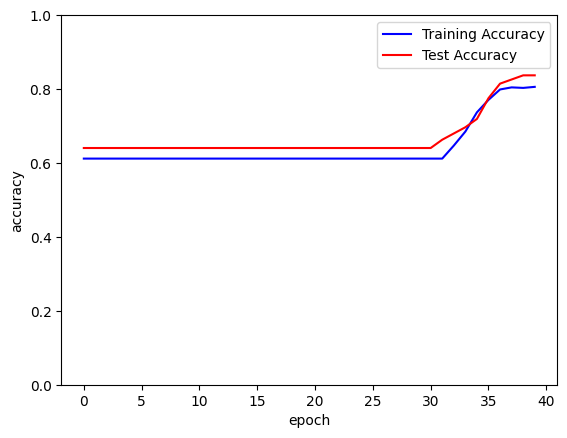

In [1585]:
import matplotlib.pyplot as plt
plt.plot(np.array(train_accuracies), color='blue', label='Training Accuracy')
plt.plot(np.array(test_accuracies), color='red', label='Test Accuracy')
# plt.scatter(test_counter, test_losses, color='red')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')